### I. Library import 


In [1]:
#Import the librairies
import ipywidgets as widgets
from ipywidgets import interact, interactive,HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import folium
import matplotlib
import mapclassify
from folium.plugins import MarkerCluster
import os

c:\Users\maube\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
#Read the data from 2024 and 2023 and concat them
data2 = pd.read_csv("data.csv",low_memory=False)
data1 = pd.read_csv("data2023.csv",low_memory=False)
data = pd.concat([data1, data2], ignore_index=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584106 entries, 0 to 1584105
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   date_mutation              1584106 non-null  object 
 1   nature_mutation            1584106 non-null  object 
 2   valeur_fonciere            1584106 non-null  float64
 3   code_commune               1584106 non-null  object 
 4   code_departement           1584106 non-null  object 
 5   id_parcelle                1584106 non-null  object 
 6   nombre_lots                1584106 non-null  int64  
 7   code_type_local            1584106 non-null  float64
 8   nombre_pieces_principales  1584106 non-null  float64
 9   surface_terrain            1584106 non-null  float64
 10  longitude                  1584106 non-null  float64
 11  latitude                   1584106 non-null  float64
 12  tranche_valeur             1584106 non-null  object 
 13  code_insee  

### II. Création des fonctions

In [4]:
def selection_filters_and_analyses(df):
    # Presentation of the filters
    type_local_map = {
        1: 'House',
        2: 'Apartment',
        3: 'Dependency (Isolated)',
        4: 'Industrial and commercial premises or similar'
    }
    df['type_local'] = df['code_type_local'].map(type_local_map)
    
    departments = df['code_departement'].unique()
    types_properties = df['type_local'].unique()
    
    # Widgets for the filters
    department_select = widgets.SelectMultiple(
        options=departments,
        value=[],
        description='Departments',
        layout=widgets.Layout(width='60%')
    )
    department_select.style.description_width = '100px'
    
    types_properties = df['type_local'].unique()
    types_properties_select = widgets.SelectMultiple(
        options=types_properties,
        value=[],
        description='Types of property',
        layout=widgets.Layout(width='60%')
    )
    types_properties_select.style.description_width = '100px'

    price_range = ["< 50k €", "50k - 100k €", "100k - 150k €", "150k - 200k €", "200k - 250k €", "250k - 300k €", "300k - 350k €", "350k - 400k €", "400k - 450k €", "450k - 500k €", "500k - 550k €", "550k - 600k €", "600k - 650k €", "650k - 700k €", "700k - 750k €", "750k - 800k €", "800k - 850k €", "850k - 900k €", "900k - 950k €", "950k - 1000M €", "1M - 1.5M €", "1.5M - 2M €", "2M - 2.5M €", "2.5M - 3M €", "3M - 4M €", "4M - 5M €", "> 5M €"]

    price_range_select = widgets.SelectMultiple(
        options=price_range,
        value=[],
        description='Price range',
        layout=widgets.Layout(width='60%')
    )
    price_range_select.style.description_width = '100px'

    slice_surface = ['0-50 m²', '50-100 m²', '100-150 m²', '150-200 m²', '200-250 m²','250-300 m²','300-350 m²','350-400 m²','400-450 m²','450-500 m²','500-600 m²','600-700 m²','700-800 m²','800-900 m²','900-1000 m²', '>1000 m²']
    slice_surface_select = widgets.SelectMultiple(
        options=slice_surface,
        value=[],
        description='Surface slice',
        layout=widgets.Layout(width='60%')
    )
    slice_surface_select.style.description_width = '100px'
    
    # Widget to sekect the analyse to execute
    disponible_analyses = {
        "Average price per m²": show_average_price_per_m2,
        "Average surface area" : show_average_surface_per_dept,
        "Price evolution" : evolution_average_price_per_m2_per_departement_monthly,
        "Number of main parts" :display_number_of_room_department,
        "Type of property by department" : distribution_type_property_by_department,
        "Distribution of land values" : distribution_of_land_value_by_tranche,
        "Price per m² depending on the surface area" : price_m2_per_surface,
        "Explore the map" : explore_france
        
    }
    
    analyse_select = widgets.SelectMultiple(
        options=list(disponible_analyses.keys()),
        description='Analyse',
        layout=widgets.Layout(width='60%')
    )
    
    analyse_select.style.description_width = '100px'
    
    # Button to apply the filters
    bouton_apply = widgets.Button(description="Apply the filters", button_style='success')

    # Function to take the filters and execute the analyse
    def apply_filter(_):
        selected_analyses = list(analyse_select.value)
        
        # We execute each analyse selected
        for analyse in selected_analyses:
            func = disponible_analyses[analyse]
            func(df, department_select, types_properties_select,price_range_select,slice_surface_select)
    
    # Link the button to the function
    bouton_apply.on_click(apply_filter)
    
    # Show widgets
    display(department_select, types_properties_select,price_range_select,slice_surface_select, analyse_select, bouton_apply)

In [5]:
def show_average_price_per_m2(df,department_select,types_properties_select,price_range_select,slice_surface_select):

    # We take the department,price range, slice surface and types of properties selected by the user
    selected_departments = list(department_select.value)
    selected_types_properties = list(types_properties_select.value)
    selected_price_range = list(price_range_select.value)
    selected_slice_surface = list(slice_surface_select.value)

    # If nothing is selected we take all the values for each point
    if not selected_departments:
        selected_departments = list(df['code_departement'].unique())
    if not selected_types_properties:
        selected_types_properties = list(df['type_local'].unique())
    if not selected_price_range:
        selected_price_range = ["< 50k €", "50k - 100k €", "100k - 150k €", "150k - 200k €", "200k - 250k €", "250k - 300k €", "300k - 350k €", "350k - 400k €", "400k - 450k €", "450k - 500k €", "500k - 550k €", "550k - 600k €", "600k - 650k €", "650k - 700k €", "700k - 750k €", "750k - 800k €", "800k - 850k €", "850k - 900k €", "900k - 950k €", "950k - 1000M €", "1M - 1.5M €", "1.5M - 2M €", "2M - 2.5M €", "2.5M - 3M €", "3M - 4M €", "4M - 5M €", "> 5M €"]
    if not selected_slice_surface:
        selected_slice_surface = ['0-50 m²', '50-100 m²', '100-150 m²', '150-200 m²', '200-250 m²','250-300 m²','300-350 m²','350-400 m²','400-450 m²','450-500 m²','500-600 m²','600-700 m²','700-800 m²','800-900 m²','900-1000 m²', '>1000 m²']
    
    # Filter data based with our filter
    df_filtered = df[(df['code_departement'].isin(selected_departments)) & 
                        (df['type_local'].isin(selected_types_properties))& 
                        (df['tranche_valeur'].isin(selected_price_range))& 
                        (df['plage_surface'].isin(selected_slice_surface))].copy()
    
    df_filtered_national = df[
                        (df['type_local'].isin(selected_types_properties))& 
                        (df['tranche_valeur'].isin(selected_price_range))& 
                        (df['plage_surface'].isin(selected_slice_surface))].copy()

    # Calculate the average price per m² by department
    average_price_par_dept = df_filtered.groupby('code_departement')['prix_m2'].mean()

    # Calculate the average price of the selected departments
    average_price_select = average_price_par_dept.mean()

    # Calculate the national average price per m²
    national_average_price = df_filtered_national[df_filtered_national['type_local'].isin(selected_types_properties)].groupby('code_departement')['prix_m2'].mean().mean()

    # we create the graph
    fig, ax = plt.subplots(figsize=(20, 6))

    # We draw a bar to show the average price for each department
    ax.bar(average_price_par_dept.index, average_price_par_dept)

    # Added a bar for the average price selected
    ax.bar('Selected Average', average_price_select, alpha=0.7)

    # Added a bar for the national average price
    ax.bar('National Average', national_average_price, alpha=0.7)

    # And this is the parameters of the graphics
    ax.set_ylabel('Average price per m² (€)')
    ax.set_xlabel('Departments')
    ax.set_title("Average price per m² per department, selected and glogal average")
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=90)
    plt.tight_layout()  # To avoid labels overlapping
    plt.show()


In [6]:
def show_average_surface_per_dept(df,department_select,types_properties_select,price_range_select,slice_surface_select):
    
    # We take the department,price range, slice surface and types of properties selected by the user
    selected_departments = list(department_select.value)
    selected_types_properties = list(types_properties_select.value)
    selected_price_range = list(price_range_select.value)
    selected_slice_surface = list(slice_surface_select.value)

    # If nothing is selected we take all the values for each point
    if not selected_departments:
        selected_departments = list(df['code_departement'].unique())
    if not selected_types_properties:
        selected_types_properties = list(df['type_local'].unique())
    if not selected_price_range:
        selected_price_range = ["< 50k €", "50k - 100k €", "100k - 150k €", "150k - 200k €", "200k - 250k €", "250k - 300k €", "300k - 350k €", "350k - 400k €", "400k - 450k €", "450k - 500k €", "500k - 550k €", "550k - 600k €", "600k - 650k €", "650k - 700k €", "700k - 750k €", "750k - 800k €", "800k - 850k €", "850k - 900k €", "900k - 950k €", "950k - 1000M €", "1M - 1.5M €", "1.5M - 2M €", "2M - 2.5M €", "2.5M - 3M €", "3M - 4M €", "4M - 5M €", "> 5M €"]
    if not selected_slice_surface:
        selected_slice_surface = ['0-50 m²', '50-100 m²', '100-150 m²', '150-200 m²', '200-250 m²','250-300 m²','300-350 m²','350-400 m²','400-450 m²','450-500 m²','500-600 m²','600-700 m²','700-800 m²','800-900 m²','900-1000 m²', '>1000 m²']
    
    # Filter data based with our filter
    df_filtered = df[(df['code_departement'].isin(selected_departments)) & 
                        (df['type_local'].isin(selected_types_properties))& 
                        (df['tranche_valeur'].isin(selected_price_range))& 
                        (df['plage_surface'].isin(selected_slice_surface))].copy()
    
    df_filtered_national = df[
                        (df['type_local'].isin(selected_types_properties))& 
                        (df['tranche_valeur'].isin(selected_price_range))& 
                        (df['plage_surface'].isin(selected_slice_surface))].copy()

    
    # We calculate the average surface area for each selected department
    average_area_par_dept = df_filtered.groupby('code_departement')['surface_terrain'].mean()

    # Calculate the average surface area of ​​the selected departments
    surface_moyenne_selectionnee = average_area_par_dept.mean()

    # Calculate the national average surface area (average of all selected departments and property types)
    national_average_area = df_filtered_national[df_filtered_national['type_local'].isin(selected_types_properties)].groupby('code_departement')['surface_terrain'].mean().mean()

    fig, ax = plt.subplots(figsize=(20, 6))

    # We plot the average area for each selected department
    ax.bar(average_area_par_dept.index, average_area_par_dept, label='Average Surface Area by Department')

    # Add a bar for the average area of the selected departments
    ax.bar('Selected Average', surface_moyenne_selectionnee, label='Selected Average', alpha=0.7)

    # Add a bar for the national average area
    ax.bar('National average', national_average_area, label='National average', alpha=0.7)

    # parameters of the graphics
    ax.set_ylabel('Average surface area in m²')
    ax.set_xlabel('Departments')
    ax.set_title("Average surface area in m² by department, selection and global average")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=90)
    plt.tight_layout()  
    plt.show()

In [7]:
def evolution_average_price_per_m2_per_departement_monthly(df,department_select,types_properties_select,price_range_select,slice_surface_select):
    # We take the department,price range, slice surface and types of properties selected by the user
    selected_departments = list(department_select.value)
    selected_types_properties = list(types_properties_select.value)
    selected_price_range = list(price_range_select.value)
    selected_slice_surface = list(slice_surface_select.value)

    # If nothing is selected we take all the values for each point
    if not selected_departments:
        selected_departments = list(df['code_departement'].unique())
    if not selected_types_properties:
        selected_types_properties = list(df['type_local'].unique())
    if not selected_price_range:
        selected_price_range = ["< 50k €", "50k - 100k €", "100k - 150k €", "150k - 200k €", "200k - 250k €", "250k - 300k €", "300k - 350k €", "350k - 400k €", "400k - 450k €", "450k - 500k €", "500k - 550k €", "550k - 600k €", "600k - 650k €", "650k - 700k €", "700k - 750k €", "750k - 800k €", "800k - 850k €", "850k - 900k €", "900k - 950k €", "950k - 1000M €", "1M - 1.5M €", "1.5M - 2M €", "2M - 2.5M €", "2.5M - 3M €", "3M - 4M €", "4M - 5M €", "> 5M €"]
    if not selected_slice_surface:
        selected_slice_surface = ['0-50 m²', '50-100 m²', '100-150 m²', '150-200 m²', '200-250 m²','250-300 m²','300-350 m²','350-400 m²','400-450 m²','450-500 m²','500-600 m²','600-700 m²','700-800 m²','800-900 m²','900-1000 m²', '>1000 m²']
    
   # Filter data based with our filter
    df_filtered = df[(df['code_departement'].isin(selected_departments)) & 
                        (df['type_local'].isin(selected_types_properties))& 
                        (df['tranche_valeur'].isin(selected_price_range))& 
                        (df['plage_surface'].isin(selected_slice_surface))].copy()
    
    df_filtered_national = df[
                        (df['type_local'].isin(selected_types_properties))& 
                        (df['tranche_valeur'].isin(selected_price_range))& 
                        (df['plage_surface'].isin(selected_slice_surface))].copy()

    # we verify that the date column is in the correct format
    df_filtered['date_mutation'] = pd.to_datetime(df_filtered['date_mutation'])

    # we take the average price per department for each month
    average_price_par_dept_mois = df_filtered.groupby(['code_departement', 'mois_annee'])['prix_m2'].mean().reset_index()


    plt.figure(figsize=(15, 8))

    # Add the curve for the global average
    df_dept_global = df_filtered.groupby('mois_annee')['prix_m2'].mean().reset_index()
    plt.plot(df_dept_global['mois_annee'].astype(str), df_dept_global['prix_m2'], marker='o', label='Moyenne générale', linewidth=2)

    # Add the curve for the national average (based on the entire data)
    df_national_global = df_filtered_national.groupby('mois_annee')['prix_m2'].mean().reset_index()
    plt.plot(df_national_global['mois_annee'].astype(str), df_national_global['prix_m2'], marker='o', label='Moyenne nationale', linewidth=2)

    # Add the curves for each selected department
    for departement in selected_departments:
        df_dept = average_price_par_dept_mois[average_price_par_dept_mois['code_departement'] == departement]
        plt.plot(df_dept['mois_annee'].astype(str), df_dept['prix_m2'], marker='o', label=f'Département {departement}')

    plt.title("Evolution of the average price per m² by department (monthly)")
    plt.xlabel("Month and year")
    plt.ylabel("Average price per m² (€)")
    plt.legend(title="Types of property", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()  
    plt.show()

In [8]:
def display_number_of_room_department(df,department_select,types_properties_select,price_range_select,slice_surface_select):
    # We take the department,price range, slice surface and types of properties selected by the user
    selected_departments = list(department_select.value)
    selected_types_properties = list(types_properties_select.value)
    selected_price_range = list(price_range_select.value)
    selected_slice_surface = list(slice_surface_select.value)

    # If nothing is selected we take all the values for each point
    if not selected_departments:
        selected_departments = list(df['code_departement'].unique())
    if not selected_types_properties:
        selected_types_properties = list(df['type_local'].unique())
    if not selected_price_range:
        selected_price_range = ["< 50k €", "50k - 100k €", "100k - 150k €", "150k - 200k €", "200k - 250k €", "250k - 300k €", "300k - 350k €", "350k - 400k €", "400k - 450k €", "450k - 500k €", "500k - 550k €", "550k - 600k €", "600k - 650k €", "650k - 700k €", "700k - 750k €", "750k - 800k €", "800k - 850k €", "850k - 900k €", "900k - 950k €", "950k - 1000M €", "1M - 1.5M €", "1.5M - 2M €", "2M - 2.5M €", "2.5M - 3M €", "3M - 4M €", "4M - 5M €", "> 5M €"]
    if not selected_slice_surface:
        selected_slice_surface = ['0-50 m²', '50-100 m²', '100-150 m²', '150-200 m²', '200-250 m²','250-300 m²','300-350 m²','350-400 m²','400-450 m²','450-500 m²','500-600 m²','600-700 m²','700-800 m²','800-900 m²','900-1000 m²', '>1000 m²']
    
     # Filter data based with our filter
    df_filtered = df[(df['code_departement'].isin(selected_departments)) & 
                        (df['type_local'].isin(selected_types_properties))& 
                        (df['tranche_valeur'].isin(selected_price_range))& 
                        (df['plage_surface'].isin(selected_slice_surface))].copy()
    
    df_filtered_national = df[
                        (df['type_local'].isin(selected_types_properties))& 
                        (df['tranche_valeur'].isin(selected_price_range))& 
                        (df['plage_surface'].isin(selected_slice_surface))].copy()

    # We take the number of main room per department
    number_piece_per_dept = df_filtered.groupby('code_departement')['nombre_pieces_principales'].mean().reset_index()

    # Ajouter la moyenne générale des départements sélectionnés
    average_selection = df_filtered['nombre_pieces_principales'].mean()
    national_average = df_filtered_national['nombre_pieces_principales'].mean()

    # Ajouter une barre pour la moyenne générale
    departments = list(number_piece_per_dept['code_departement'])
    number_room = list(number_piece_per_dept['nombre_pieces_principales'])

    plt.figure(figsize=(15, 8))
    plt.bar(departments, number_room, color='skyblue')
    #We plot line for average and national average of main rooms
    plt.axhline(average_selection, color='red', linestyle='dashed', linewidth=2, label='Selected average')
    plt.axhline(national_average, color='green', linestyle='dashed', linewidth=2, label='National average')

    plt.title("Average number of rooms per department and per type of property selected")
    plt.xlabel("Department")
    plt.ylabel("Average number of rooms")
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()  
    plt.show()

In [9]:
def distribution_type_property_by_department(df,department_select,types_properties_select,price_range_select,slice_surface_select):
    # We take the department,price range, slice surface and types of properties selected by the user
    selected_departments = list(department_select.value)
    selected_types_properties = list(types_properties_select.value)
    selected_price_range = list(price_range_select.value)
    selected_slice_surface = list(slice_surface_select.value)

   # If nothing is selected we take all the values for each point
    if not selected_departments:
        selected_departments = list(df['code_departement'].unique())
    if not selected_types_properties:
        selected_types_properties = list(df['type_local'].unique())
    if not selected_price_range:
        selected_price_range = list(df['tranche_valeur'].unique())
    if not selected_slice_surface:
        selected_slice_surface = list(df['plage_surface'].unique())
    
     # Filter data based with our filter
    df_filtered = df[(df['code_departement'].isin(selected_departments)) & 
                        (df['type_local'].isin(selected_types_properties))& 
                        (df['tranche_valeur'].isin(selected_price_range))& 
                        (df['plage_surface'].isin(selected_slice_surface))].copy()

    # Calculate the distribution of property types by department
    distribution = df_filtered.groupby(['code_departement', 'type_local']).size().unstack(fill_value=0)

    # Normalize to obtain proportions (in %)
    distribution_norm = distribution.div(distribution.sum(axis=1), axis=0) * 100

    # creating a Stacked Bar Chart
    distribution_norm.plot(kind='bar', figsize=(15, 8), stacked=True, colormap='tab20')

    plt.title("Distribution of transactions by type of property and by department")
    plt.xlabel("Department")
    plt.ylabel("Proportion of transactions (%)")
    plt.legend(title="Types of properties", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [10]:
def distribution_of_land_value_by_tranche(df, department_select, types_properties_select, price_range_select, slice_surface_select):
    # Ordered list of price ranges
    price_order = [
        "< 50k €", "50k - 100k €", "100k - 150k €", "150k - 200k €", "200k - 250k €",
        "250k - 300k €", "300k - 350k €", "350k - 400k €", "400k - 450k €", "450k - 500k €",
        "500k - 550k €", "550k - 600k €", "600k - 650k €", "650k - 700k €", "700k - 750k €",
        "750k - 800k €", "800k - 850k €", "850k - 900k €", "900k - 950k €", "950k - 1000M €",
        "1M - 1.5M €", "1.5M - 2M €", "2M - 2.5M €", "2.5M - 3M €", "3M - 4M €", "4M - 5M €", "> 5M €"
    ]

    # Transform the 'tranche_valeur' column into an ordered category
    df['tranche_valeur'] = pd.Categorical(df['tranche_valeur'], categories=price_order, ordered=True)

    # Selections
    selected_departments = list(department_select.value)
    selected_types_properties = list(types_properties_select.value)
    selected_price_range = list(price_range_select.value)
    selected_slice_surface = list(slice_surface_select.value)

    # Default to all if no selections
    if not selected_departments:
        selected_departments = list(df['code_departement'].unique())
    if not selected_types_properties:
        selected_types_properties = list(df['type_local'].unique())
    if not selected_price_range:
        selected_price_range = price_order
    if not selected_slice_surface:
        selected_slice_surface = ['0-50 m²', '50-100 m²', '100-150 m²', '150-200 m²', '200-250 m²',
                                  '250-300 m²', '300-350 m²', '350-400 m²', '400-450 m²', '450-500 m²',
                                  '500-600 m²', '600-700 m²', '700-800 m²', '800-900 m²', '900-1000 m²', '>1000 m²']

    # Filter data
    df_filtered = df[(df['code_departement'].isin(selected_departments)) &
                     (df['type_local'].isin(selected_types_properties)) &
                     (df['tranche_valeur'].isin(selected_price_range)) &
                     (df['plage_surface'].isin(selected_slice_surface))].copy()

    # Count the number of transactions by tranche and by department
    distribution = df_filtered.groupby(['tranche_valeur', 'code_departement']).size().unstack(fill_value=0)

    # Calculate percentages relative to each department's total
    distribution_percentage = distribution.div(distribution.sum(axis=0), axis=1) * 100

    # Plot side-by-side bar chart
    ax = distribution_percentage.plot(kind='bar', figsize=(15, 8), width=0.8, colormap='tab10')

    # Update plot settings
    plt.title("Distribution of transactions by land value range and by department (in %)")
    plt.xlabel("Land value range (€)")
    plt.ylabel("Percentage of transactions (%)")
    plt.legend(title="Department", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [11]:
def price_m2_per_surface(df, department_select, types_properties_select,price_range_select,slice_surface_select):
    # We take the department,price range, slice surface and types of properties selected by the user
    selected_departments = list(department_select.value)
    selected_types_properties = list(types_properties_select.value)
    selected_price_range = list(price_range_select.value)
    selected_slice_surface = list(slice_surface_select.value)

    # If nothing is selected we take all the values for each point
    if not selected_departments:
        selected_departments = list(df['code_departement'].unique())
    if not selected_types_properties:
        selected_types_properties = list(df['type_local'].unique())
    if not selected_price_range:
        selected_price_range = ["< 50k €", "50k - 100k €", "100k - 150k €", "150k - 200k €", "200k - 250k €", "250k - 300k €", "300k - 350k €", "350k - 400k €", "400k - 450k €", "450k - 500k €", "500k - 550k €", "550k - 600k €", "600k - 650k €", "650k - 700k €", "700k - 750k €", "750k - 800k €", "800k - 850k €", "850k - 900k €", "900k - 950k €", "950k - 1000M €", "1M - 1.5M €", "1.5M - 2M €", "2M - 2.5M €", "2.5M - 3M €", "3M - 4M €", "4M - 5M €", "> 5M €"]
    if not selected_slice_surface:
        selected_slice_surface = ['0-50 m²', '50-100 m²', '100-150 m²', '150-200 m²', '200-250 m²','250-300 m²','300-350 m²','350-400 m²','400-450 m²','450-500 m²','500-600 m²','600-700 m²','700-800 m²','800-900 m²','900-1000 m²', '>1000 m²']
    
     # Filter data based with our filter
    df_filtered = df[(df['code_departement'].isin(selected_departments)) & 
                        (df['type_local'].isin(selected_types_properties))& 
                        (df['tranche_valeur'].isin(selected_price_range))& 
                        (df['plage_surface'].isin(selected_slice_surface))].copy()

    df_filtered_national = df[
                        (df['type_local'].isin(selected_types_properties))& 
                        (df['tranche_valeur'].isin(selected_price_range))& 
                        (df['plage_surface'].isin(selected_slice_surface))].copy()
    
    # Calculate the average price by surface area and department
    average_price_per_surface = df_filtered.groupby(['plage_surface', 'code_departement'])['prix_m2'].mean().reset_index()
    
     # Calculate average by surface range for selection
    average_selection = df_filtered.groupby('plage_surface')['prix_m2'].mean().reset_index()

    # Calculate the national average by surface area
    national_average = df_filtered_national.groupby('plage_surface')['prix_m2'].mean().reset_index()

    # Creating the graph
    plt.figure(figsize=(12, 8))
    #For each department selected, we take the average price per suface and then we plot the point of the selected average  
    for department in selected_departments:
        df_department = average_price_per_surface[average_price_per_surface['code_departement'] == department]
        if not df_department.empty:
            plt.plot(
                df_department['plage_surface'], 
                df_department['prix_m2'], 
                marker='o', 
                label=f'Department {department}'
            )
    plt.plot(
        average_selection['plage_surface'], 
        average_selection['prix_m2'], 
        marker='o', 
        linestyle='--', 
        label='Selected average', 
        color='black'
    )

    # Then we add the National average line
    plt.plot(
        national_average['plage_surface'], 
        national_average['prix_m2'], 
        marker='o', 
        linestyle=':', 
        label='National average', 
        color='red'
    )

    # graph configurations
    plt.title("Average price per m² depending on surface area ranges")
    plt.xlabel("Surface range (m²)")
    plt.ylabel("Average price per m² (€)")
    plt.legend(title="Departement", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [12]:
def add_region_name_column(df):
    """
    Add a column 'region_name' to the dataframe with the name of the region corresponding to the INSEE code.

    :param df: DataFrame with the column 'code_insee' containing the INSEE codes of the departments
    
    :return: DataFrame with the added column 'region_name'
    """
    # Dictionary of INSEE codes for regions and their names
    regions_names = {
        "01": "Guadeloupe", "02": "Martinique", "03": "Guyane", "04": "La Réunion", "06": "Mayotte", "11": "Île-de-France",
        "24": "Centre-Val de Loire", "27": "Bourgogne-Franche-Comté", "28": "Normandie", "32": "Hauts-de-France",
        "44": "Grand Est", "52": "Pays de la Loire", "53": "Bretagne", "75": "Nouvelle-Aquitaine", "76": "Occitanie",
        "84": "Auvergne-Rhône-Alpes", "93": "Provence-Alpes-Côte d'Azur", "94": "Corse"
    }
    df['region_name'] = df['code_insee'].map(regions_names)
    return df

In [13]:
def explore_france(data, department_select=None, types_properties_select=None, price_range_select=None, slice_surface_select=None):
    """
    Displays a map of France with the average price per m² of land by region, and the location of the transactions.

    Parameters:
    - data : pd.DataFrame : The DataFrame containing the data of real estate transactions.
    - department_select : ipywidgets.SelectMultiple : The widget for selecting departments.
    - types_properties_select : ipywidgets.SelectMultiple : The widget for selecting property types.
    - price_range_select : ipywidgets.SelectMultiple : The widget for selecting price ranges.
    - slice_surface_select : ipywidgets.SelectMultiple : The widget for selecting surface ranges.

    Returns:
    - Map of France with the average price per m² of land by region, and the location of the transactions.
    
    """
    data_general = data.copy()
    
    #We take the department,price range, slice surface and types of properties selected by the user
    selected_departments = list(department_select.value)
    selected_types_properties = list(types_properties_select.value)
    selected_price_range = list(price_range_select.value)
    selected_slice_surface = list(slice_surface_select.value)
    # If nothing is selected we take all the values for each point
    if not selected_departments:
        selected_departments = list(data['code_departement'].unique())
    if not selected_types_properties:
        selected_types_properties = list(data['type_local'].unique())
    if not selected_price_range:
        selected_price_range = ["< 50k €", "50k - 100k €", "100k - 150k €", "150k - 200k €", "200k - 250k €", "250k - 300k €", "300k - 350k €", "350k - 400k €", "400k - 450k €", "450k - 500k €", "500k - 550k €", "550k - 600k €", "600k - 650k €", "650k - 700k €", "700k - 750k €", "750k - 800k €", "800k - 850k €", "850k - 900k €", "900k - 950k €", "950k - 1000M €", "1M - 1.5M €", "1.5M - 2M €", "2M - 2.5M €", "2.5M - 3M €", "3M - 4M €", "4M - 5M €", "> 5M €"]
    if not selected_slice_surface:
        selected_slice_surface = ['0-50 m²', '50-100 m²', '100-150 m²', '150-200 m²', '200-250 m²','250-300 m²','300-350 m²','350-400 m²','400-450 m²','450-500 m²','500-600 m²','600-700 m²','700-800 m²','800-900 m²','900-1000 m²', '>1000 m²']
    
    # Filter data based with our filter
    data = data[
        (data['code_departement'].isin(selected_departments)) &
        (data['type_local'].isin(selected_types_properties)) &
        (data['tranche_valeur'].isin(selected_price_range)) &
        (data['plage_surface'].isin(selected_slice_surface))
    ].copy()

    # Load shapefile
    shp_file_path = "regions.shx"
    map_france = gpd.read_file(shp_file_path)

    # Define the CRS
    if map_france.crs is None:
        map_france = map_france.set_crs(epsg=4326, allow_override=True)

    #We verify that the column 'code_insee' is in the correct format and correct it if necessary
    data_general["code_insee"] = data_general["code_insee"].astype(str).str.zfill(2)

    #Average price per m² by region
    ratio_average = data_general.groupby('code_insee')['prix_m2'].mean()
    
    # Add the average land value by region stylized in euros
    map_france['Average_land_value'] = map_france['code_insee'].map(ratio_average)
    map_france['Average_land_value'] = map_france['Average_land_value'].apply(lambda x: f"{x:.0f} €")
   

    # Normalize the values
    ratio_average = (ratio_average - ratio_average.min()) / (ratio_average.max() - ratio_average.min())

    # Logarithmic transformation to accentuate differences
    ratio_average = np.log1p(ratio_average * 10)

    map_france = map_france.set_index('code_insee').join(ratio_average, how='left').reset_index()
    map_france = add_region_name_column(map_france)

    sample_data = data.copy() if department_select and types_properties_select and price_range_select and slice_surface_select else data_general.sample(1000, random_state=42)

    geometry = gpd.GeoSeries.from_xy(sample_data['longitude'], sample_data['latitude'])
    points_gdf = gpd.GeoDataFrame(sample_data, geometry=geometry)

    # Creating the map
    map = folium.Map(location=[46.603354, 1.888334], zoom_start=6)
    map_france["prix_m2"].fillna(0, inplace=True)
    # We add the regions to the map
    folium.GeoJson(
        map_france,
        name='geojson',
        style_function=lambda feature: {
            'fillColor':  matplotlib.colors.rgb2hex(plt.cm.plasma(feature['properties']['prix_m2'])),
            'color': matplotlib.colors.rgb2hex(plt.cm.plasma(feature['properties']['prix_m2'])),
            'weight': 2,
            'fillOpacity': 0.5,
        },
        tooltip=folium.GeoJsonTooltip(fields=['region_name', 'Average_land_value']),
        
    ).add_to(map)

    # Add some points
    marker_cluster = MarkerCluster().add_to(map)
    #We added popup to each properties to display information about the property
    for idx, row in points_gdf.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"{row.get('region_name', 'N/A')} \n Type : {row.get('type_local', 'N/A')} \n {row.get('valeur_fonciere', 'N/A')} € \n {row.get('surface_terrain', 'N/A')} m² ",
            icon=folium.Icon(color='red', icon='home')
        ).add_to(marker_cluster)

    display(map)
    return map


### III. Exécution des fonctions

SelectMultiple(description='Departments', layout=Layout(width='60%'), options=('01', '02', '03', '04', '05', '…

SelectMultiple(description='Types of property', layout=Layout(width='60%'), options=('House', 'Dependency (Iso…

SelectMultiple(description='Price range', layout=Layout(width='60%'), options=('< 50k €', '50k - 100k €', '100…

SelectMultiple(description='Surface slice', layout=Layout(width='60%'), options=('0-50 m²', '50-100 m²', '100-…

SelectMultiple(description='Analyse', layout=Layout(width='60%'), options=('Average price per m²', 'Average su…

Button(button_style='success', description='Apply the filters', style=ButtonStyle())

C:\Users\maube\AppData\Local\Temp\ipykernel_2944\1362677495.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distribution = df_filtered.groupby(['tranche_valeur', 'code_departement']).size().unstack(fill_value=0)


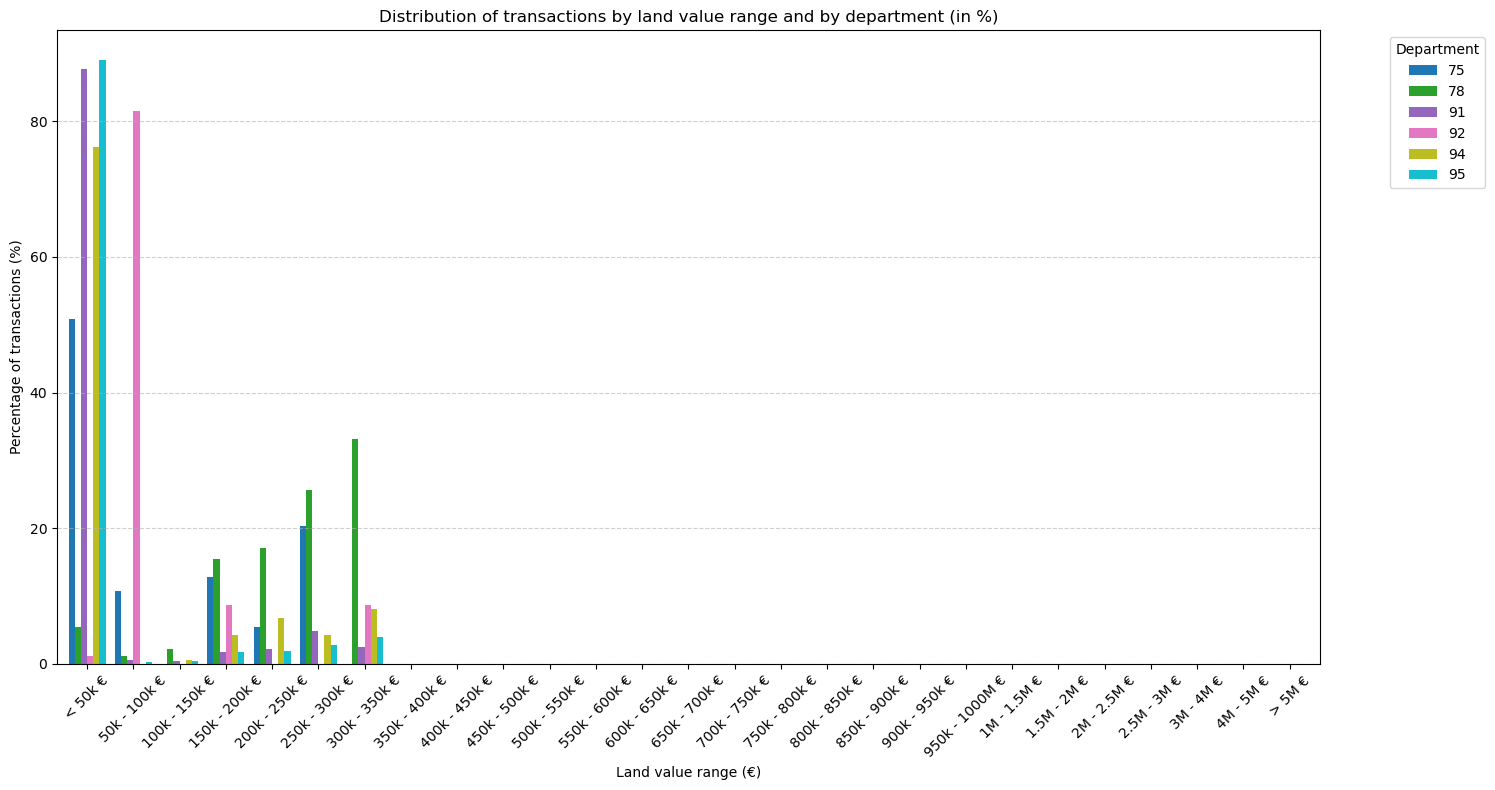

In [14]:
selection_filters_and_analyses(data)